# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import math
from typing import List
from datetime import datetime

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

from prophet import Prophet

from sklearn.metrics import mean_absolute_error

# Functions

In [2]:
def _numerical_eda(df: pd.DataFrame,
                   features: List[str]
                  ) -> pd.DataFrame:
    """
    Exploratory data analysis of numerical features
    """
    df = df[features]

    len_list = []
    null_list = []
    prop_null_list = []
    mean_list = []
    std_list = []
    min_list = []
    per_1_list = []
    per_25_list = []
    median_list = []
    per_75_list = []
    per_99_list = []
    max_list = []

    for i in features:
        len_v = len(df)
        len_list.append(len_v)
        null_v = df[i].isnull().sum()
        null_list.append(null_v)
        prop_null_v = null_v/len_v
        prop_null_list.append(prop_null_v)
        mean_v = np.mean(df[i])
        mean_list.append(mean_v)
        std_v = np.std(df[i])
        std_list.append(std_v)
        min_v = np.min(df[i])
        min_list.append(min_v)
        per_1_v = np.percentile(df[i].dropna(), 1)
        per_1_list.append(per_1_v)
        per_25_v = np.percentile(df[i].dropna(), 25)
        per_25_list.append(per_25_v)
        median_v = np.median(df[i].dropna())
        median_list.append(median_v)
        per_75_v = np.percentile(df[i].dropna(), 75)
        per_75_list.append(per_75_v)
        per_99_v = np.percentile(df[i].dropna(), 99)
        per_99_list.append(per_99_v)
        max_v = np.max(df[i])
        max_list.append(max_v)

    df = pd.DataFrame({"feature": features,
                       "n_row": len_list,
                       "n_col": len(features),
                       "num_null": null_list,
                       "prop_null": prop_null_list,
                       "mean": mean_list,
                       "std": std_list,
                       "min": min_list,
                       "per_1": per_1_list,
                       "per_25": per_25_list,
                       "median": median_list,
                       "per_75": per_75_list,
                       "per_99": per_99_list,
                       "max": max_list
                      })
    df  = df.sort_values(by=["feature"])
    df = df.reset_index(drop=True)
    return df

def _time_series_nas(df: pd.DataFrame,
                     date_col: str,
                     freq: str
                     ):
  """
  Check if exists missing values in time series
  """
  full_date_range = pd.date_range(start=df[date_col].min(), end=df[date_col].max(), freq=freq)
  missing_dates = full_date_range[~full_date_range.isin(df[date_col])]
  len_missing_dates = len(missing_dates)
  if len_missing_dates == 0:
    print("The time series is complete")
  else:
    print(f"The time series has {len_missing_dates} missing dates")
  return missing_dates

def _plt_histogram(df: pd.DataFrame,
                   features: List[str]
                  ):
    """
    Plot a histogram for every numerical column in features argument
    """
    df[features].hist(figsize=(8, 4))
    plt.tight_layout()
    plt.show()

def _plt_boxplot(df: pd.DataFrame,
                 features: List[str]
                ):
    """
    Plot a boxplot for every numerical column in features argument
    """
    k = _plt_boxplot_grid(features)
    plt.figure(figsize=(10, k*10))

    props_dict = {'linewidth': 2,
                  'color': '#2773B2'
                 }

    for n, ticker in enumerate(features):
        ax = plt.subplot(k*3, 3, n + 1)

        df[[ticker]].boxplot(boxprops=props_dict,
                             medianprops=props_dict,
                             whiskerprops=props_dict,
                             capprops=props_dict
                            )
    plt.tight_layout()
    plt.show()

def _plt_boxplot_grid(features):
    return math.ceil(len(features)/3)

def _plot_time_series(df, x, y, title="", dpi=100, rotation=0, fontsize=10, y_bottom=None, marker=None):
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.plot(df[x], df[y], color='tab:red', marker=marker, markerfacecolor='black')
    plt.xticks(rotation=rotation, fontsize=fontsize)
    plt.ylim(bottom=y_bottom)
    plt.gca().set(title=title, xlabel=x, ylabel=y)
    plt.show()

# Load data

In [3]:
data = pd.read_csv("forecasting_challenge_data.csv")

# First look

In [3]:
data.head()

,LOCAL_DATETIME,DELIVERED_ORDERS,CANCELED_ORDERS
0,2021-03-02T00:00:00Z,122,20
1,2021-03-02T01:00:00Z,86,6
2,2021-03-02T02:00:00Z,38,6
3,2021-03-02T03:00:00Z,25,10
4,2021-03-02T04:00:00Z,14,6


In [4]:
print(data.shape)
data.dtypes

(25343, 3)


LOCAL_DATETIME      object
DELIVERED_ORDERS     int64
CANCELED_ORDERS      int64
dtype: object

In [6]:
print(data['LOCAL_DATETIME'].min())
print(data['LOCAL_DATETIME'].max())

2021-03-02T00:00:00Z
2024-01-22T23:00:00Z


# Missing values

Identify missing values:

In [4]:
missing_dates = _time_series_nas(data, 'LOCAL_DATETIME', 'h')

The time series has 25 missing dates


In [9]:
for date in missing_dates:
  print(date)

2022-12-25 06:00:00+00:00
2022-12-31 22:00:00+00:00
2022-12-31 23:00:00+00:00
2023-01-01 01:00:00+00:00
2023-01-01 02:00:00+00:00
2023-01-01 03:00:00+00:00
2023-01-01 04:00:00+00:00
2023-03-23 02:00:00+00:00
2023-12-24 23:00:00+00:00
2023-12-25 00:00:00+00:00
2023-12-25 01:00:00+00:00
2023-12-25 02:00:00+00:00
2023-12-25 03:00:00+00:00
2023-12-25 04:00:00+00:00
2023-12-25 05:00:00+00:00
2023-12-25 06:00:00+00:00
2023-12-31 22:00:00+00:00
2023-12-31 23:00:00+00:00
2024-01-01 01:00:00+00:00
2024-01-01 02:00:00+00:00
2024-01-01 03:00:00+00:00
2024-01-01 04:00:00+00:00
2024-01-01 05:00:00+00:00
2024-01-01 06:00:00+00:00
2024-01-01 07:00:00+00:00


Descriptive statistics for missing hours of data:

In [10]:
data['hour'] = pd.DatetimeIndex(data['LOCAL_DATETIME']).hour

In [13]:
features = ['CANCELED_ORDERS', 'DELIVERED_ORDERS']
_numerical_eda(data.query("(hour >= 0 and hour <= 7) or (hour >= 22 and hour <= 23)"), features)

,feature,n_row,n_col,num_null,prop_null,mean,std,min,per_1,per_25,median,per_75,per_99,max
0,CANCELED_ORDERS,10545,2,0,0.0,46.335609,53.031573,0,2.0,14.0,29.0,58.0,257.56,604
1,DELIVERED_ORDERS,10545,2,0,0.0,645.751731,727.819362,0,12.0,102.0,353.0,946.0,3233.28,4594


Imputation of missing values:

In [5]:
for date in missing_dates:
  new_row = {'LOCAL_DATETIME': date, 'DELIVERED_ORDERS': 353, 'CANCELED_ORDERS': 29}
  data.loc[len(data)] = new_row

data['LOCAL_DATETIME'] = pd.to_datetime(data['LOCAL_DATETIME']).dt.strftime('%Y-%m-%d %H')
data = data.sort_values(by=['LOCAL_DATETIME']).reset_index()

In [6]:
missing_dates = _time_series_nas(data, 'LOCAL_DATETIME', 'h')

The time series is complete


# Feature engineering

In [7]:
data['year'] = pd.DatetimeIndex(data['LOCAL_DATETIME']).year
data['month'] = pd.DatetimeIndex(data['LOCAL_DATETIME']).month
data['day'] = pd.DatetimeIndex(data['LOCAL_DATETIME']).day
data['hour'] = pd.DatetimeIndex(data['LOCAL_DATETIME']).hour
data['day_name'] = pd.DatetimeIndex(data['LOCAL_DATETIME']).day_name()
data['date_day_name'] = data['LOCAL_DATETIME'] + ", " + data['day_name']

In [18]:
data.head()

,index,LOCAL_DATETIME,DELIVERED_ORDERS,CANCELED_ORDERS,hour,year,month,day,day_name,date_day_name
0,0,2021-03-02 00,122,20,0,2021,3,2,Tuesday,"2021-03-02 00, Tuesday"
1,1,2021-03-02 01,86,6,1,2021,3,2,Tuesday,"2021-03-02 01, Tuesday"
2,2,2021-03-02 02,38,6,2,2021,3,2,Tuesday,"2021-03-02 02, Tuesday"
3,3,2021-03-02 03,25,10,3,2021,3,2,Tuesday,"2021-03-02 03, Tuesday"
4,4,2021-03-02 04,14,6,4,2021,3,2,Tuesday,"2021-03-02 04, Tuesday"


# EDA

In [20]:
_numerical_eda(data, features)

,feature,n_row,n_col,num_null,prop_null,mean,std,min,per_1,per_25,median,per_75,per_99,max
0,CANCELED_ORDERS,25393,2,0,0.0,139.129445,125.553393,0,4.0,36.0,113.0,203.0,541.00,2167
1,DELIVERED_ORDERS,25393,2,0,0.0,4076.552357,3710.622909,0,20.0,510.0,3230.0,6685.0,13258.08,19622


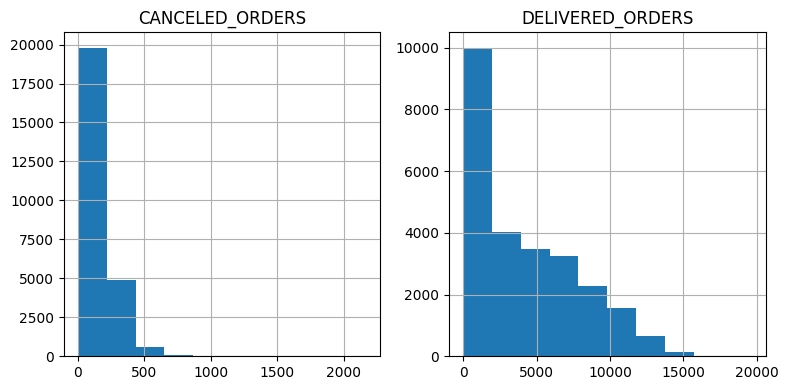

In [21]:
_plt_histogram(data, features)

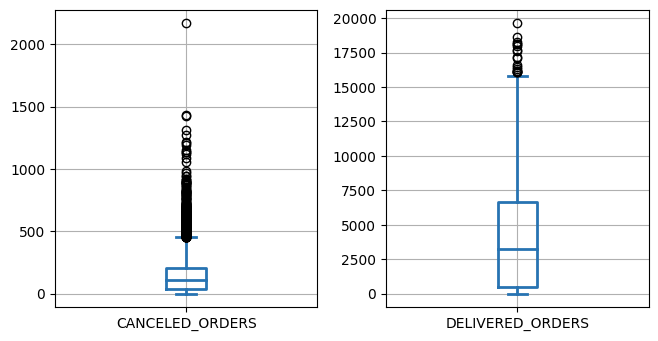

In [22]:
_plt_boxplot(data, features)

                  CANCELED_ORDERS  DELIVERED_ORDERS
CANCELED_ORDERS          1.000000          0.785134
DELIVERED_ORDERS         0.785134          1.000000


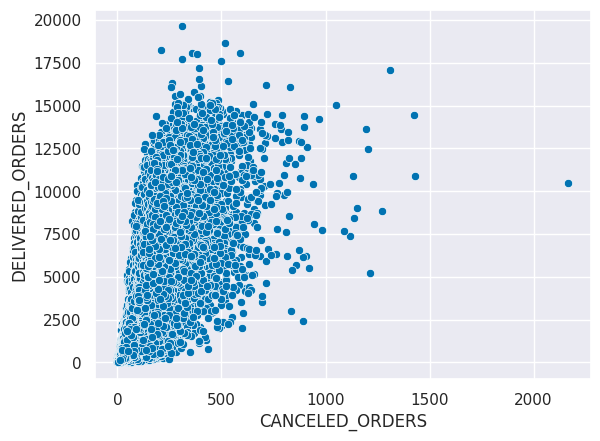

In [ ]:
print(data[features].corr())
sns.set(style='darkgrid', palette='colorblind')
sns.scatterplot(x='CANCELED_ORDERS', y='DELIVERED_ORDERS', data=data)
plt.show()

# Time series EDA

In [24]:
df_year = (data
           .groupby(['year'])
           .agg({'DELIVERED_ORDERS': 'sum',
                 'CANCELED_ORDERS': 'sum',
                 'date_day_name': 'last',
                 })
           .reset_index()
           )

df_month = (data
            .groupby(['year', 'month'])
            .agg({'DELIVERED_ORDERS': 'sum',
                  'CANCELED_ORDERS': 'sum',
                  'date_day_name': 'last',
                  })
            .reset_index()
            )

df_day = (data
          .groupby(['year', 'month', 'day'])
          .agg({'DELIVERED_ORDERS': 'sum',
                'CANCELED_ORDERS': 'sum',
                'date_day_name': 'last',
                })
          .reset_index()
          )

Complete time series:

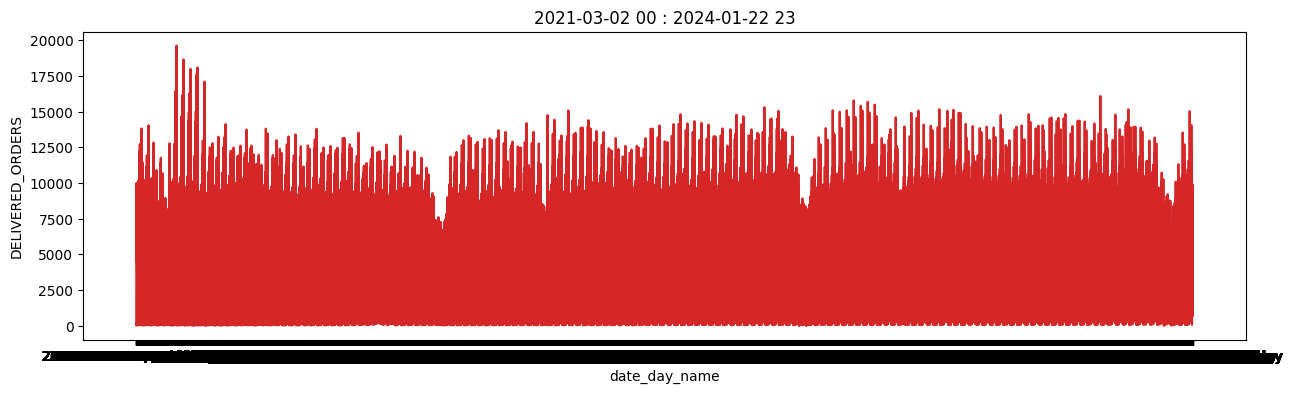

In [29]:
_plot_time_series(data, 'date_day_name', 'DELIVERED_ORDERS', title="2021-03-02 00 : 2024-01-22 23")

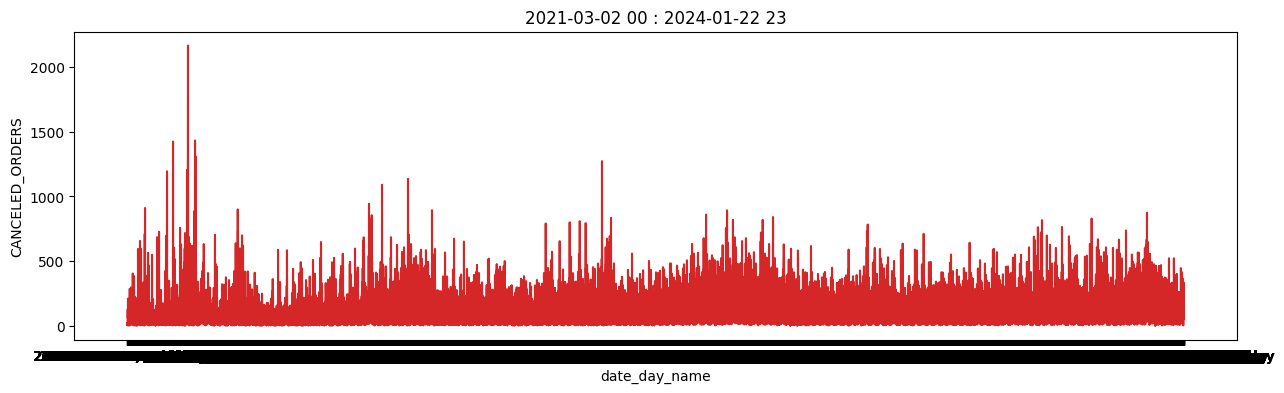

In [28]:
_plot_time_series(data, 'date_day_name', 'CANCELED_ORDERS', title="2021-03-02 00 : 2024-01-22 23")

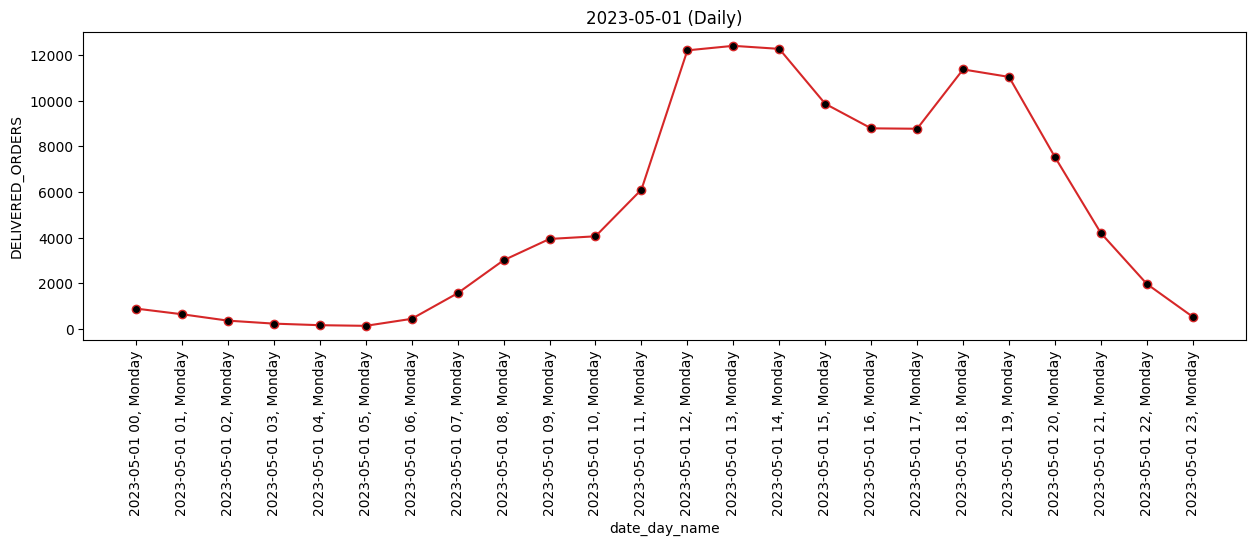

In [53]:
_plot_time_series(data.query("year == 2023 and month == 5 and day == 1"), 'date_day_name', 'DELIVERED_ORDERS', title="2023-05-01 (Daily)", rotation=90, marker='o')

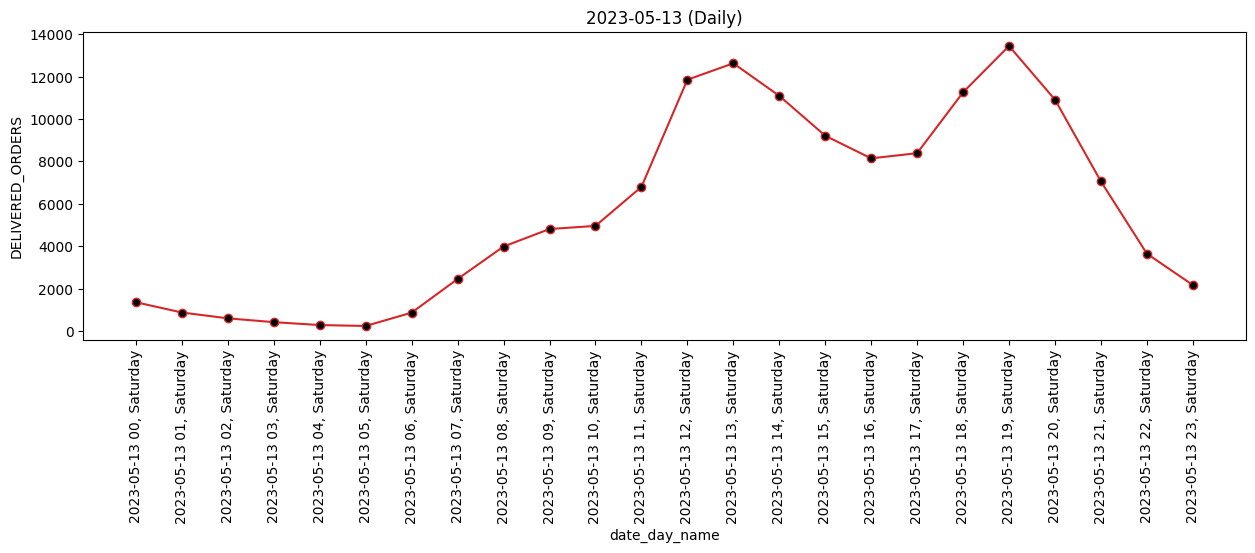

In [54]:
_plot_time_series(data.query("year == 2023 and month == 5 and day == 13"), 'date_day_name', 'DELIVERED_ORDERS', title="2023-05-13 (Daily)", rotation=90, marker='o')

Daily time series:

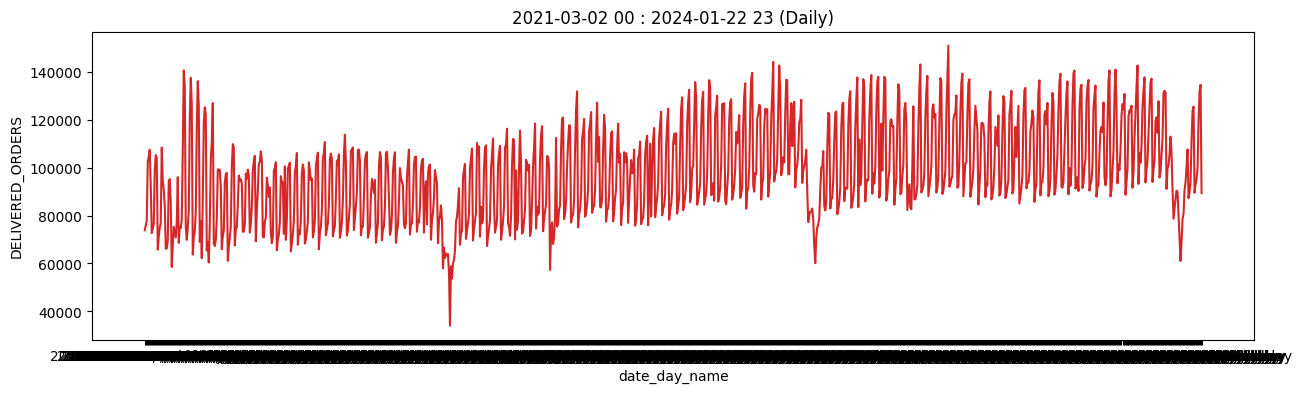

In [30]:
_plot_time_series(df_day, 'date_day_name', 'DELIVERED_ORDERS', title="2021-03-02 00 : 2024-01-22 23 (Daily)")

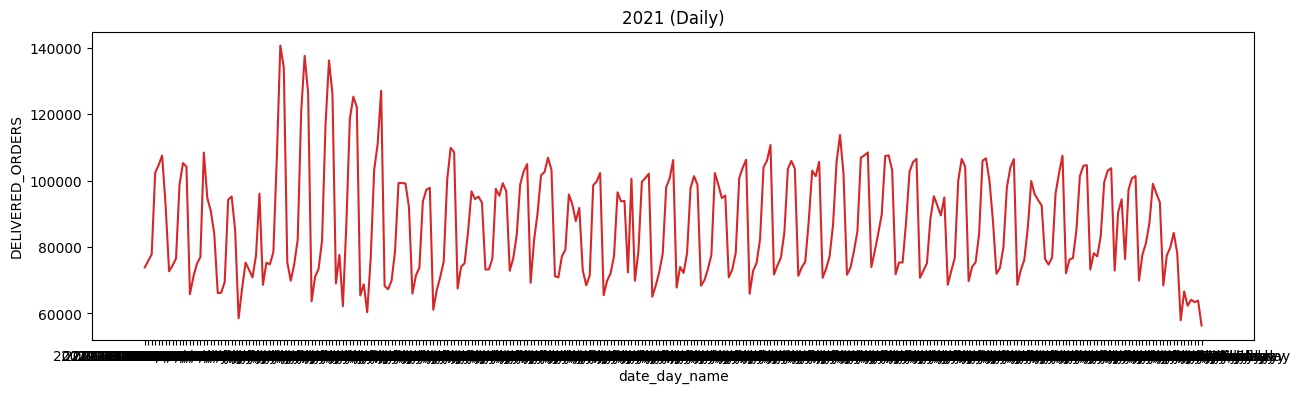

In [33]:
_plot_time_series(df_day.query("year == 2021"), 'date_day_name', 'DELIVERED_ORDERS', title="2021 (Daily)")

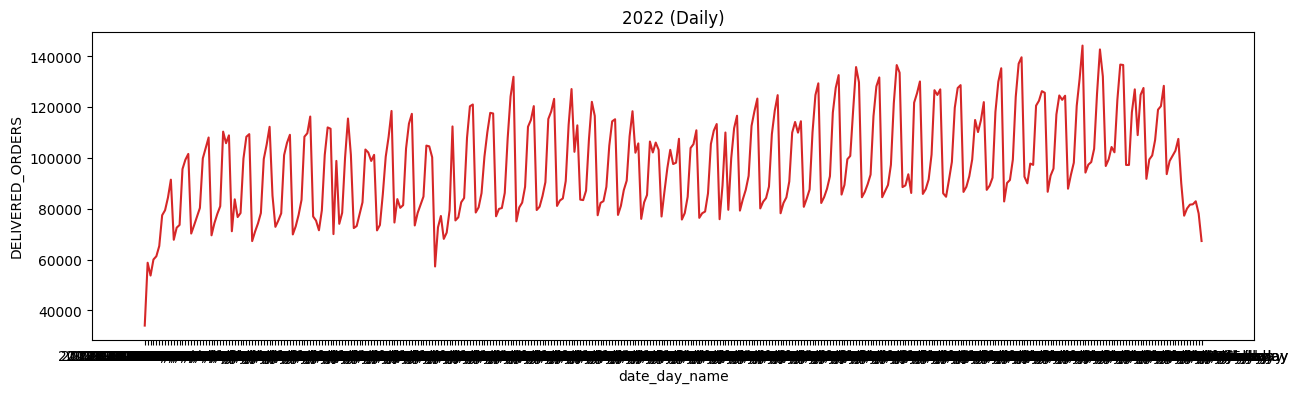

In [32]:
_plot_time_series(df_day.query("year == 2022"), 'date_day_name', 'DELIVERED_ORDERS', title="2022 (Daily)")

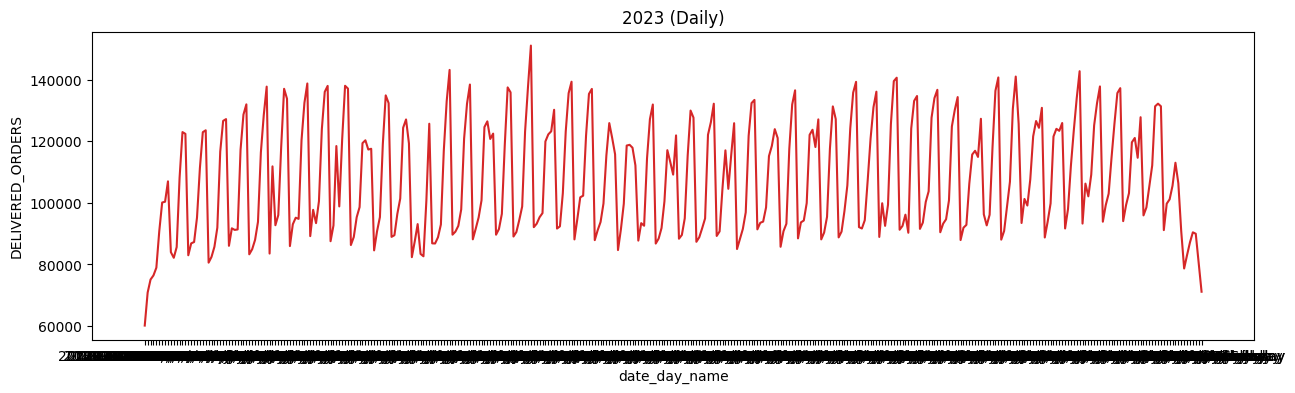

In [48]:
_plot_time_series(df_day.query("year == 2023"), 'date_day_name', 'DELIVERED_ORDERS', title="2023 (Daily)")

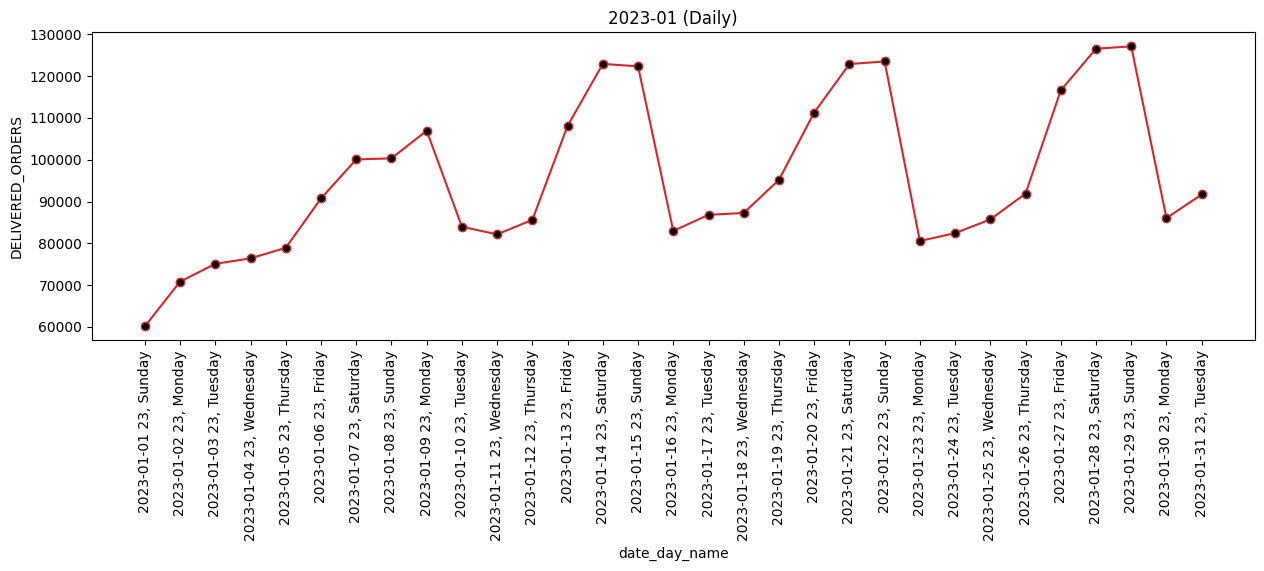

In [46]:
_plot_time_series(df_day.query("year == 2023 and month == 1"), 'date_day_name', 'DELIVERED_ORDERS', title="2023-01 (Daily)", rotation=90, marker='o')

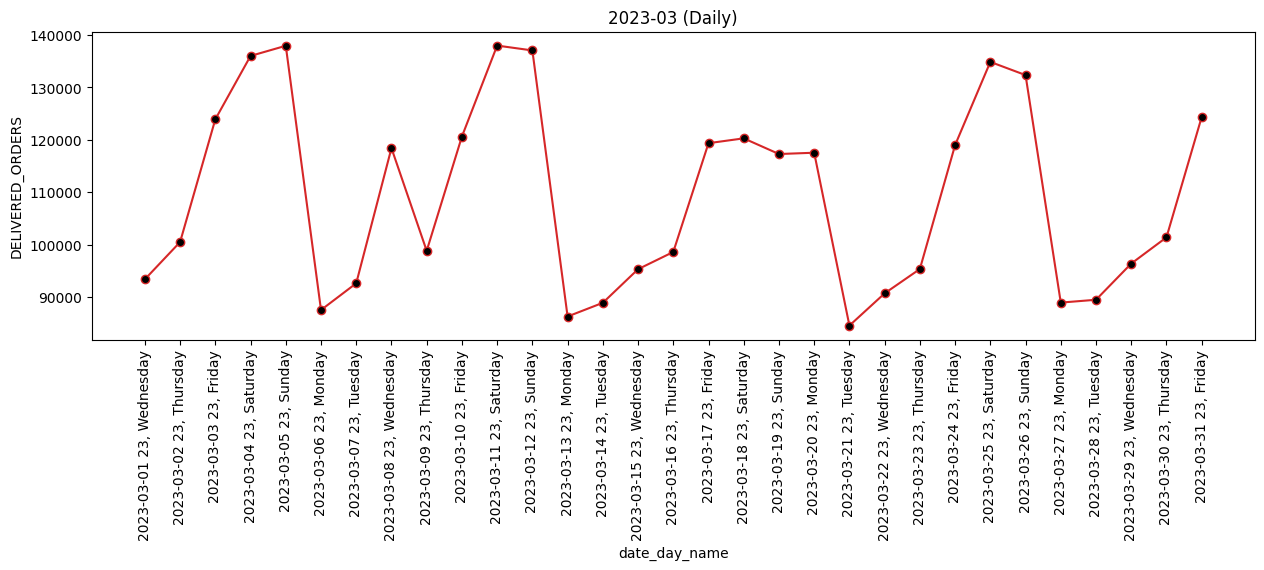

In [45]:
_plot_time_series(df_day.query("year == 2023 and month == 3"), 'date_day_name', 'DELIVERED_ORDERS', title="2023-03 (Daily)", rotation=90, marker='o')

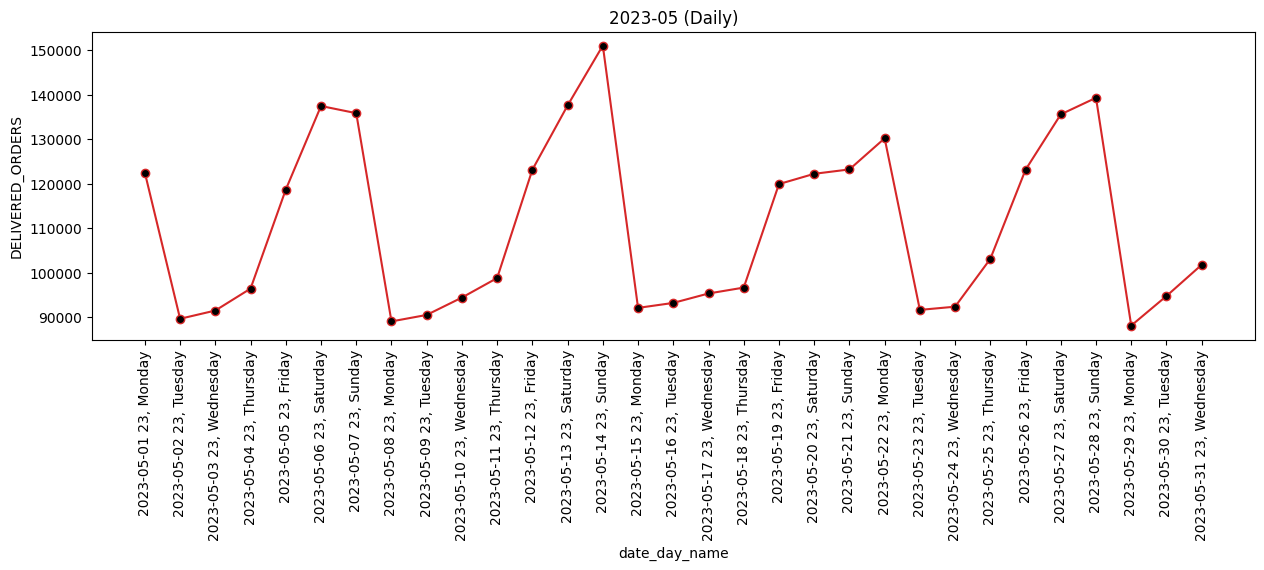

In [49]:
_plot_time_series(df_day.query("year == 2023 and month == 5"), 'date_day_name', 'DELIVERED_ORDERS', title="2023-05 (Daily)", rotation=90, marker='o')

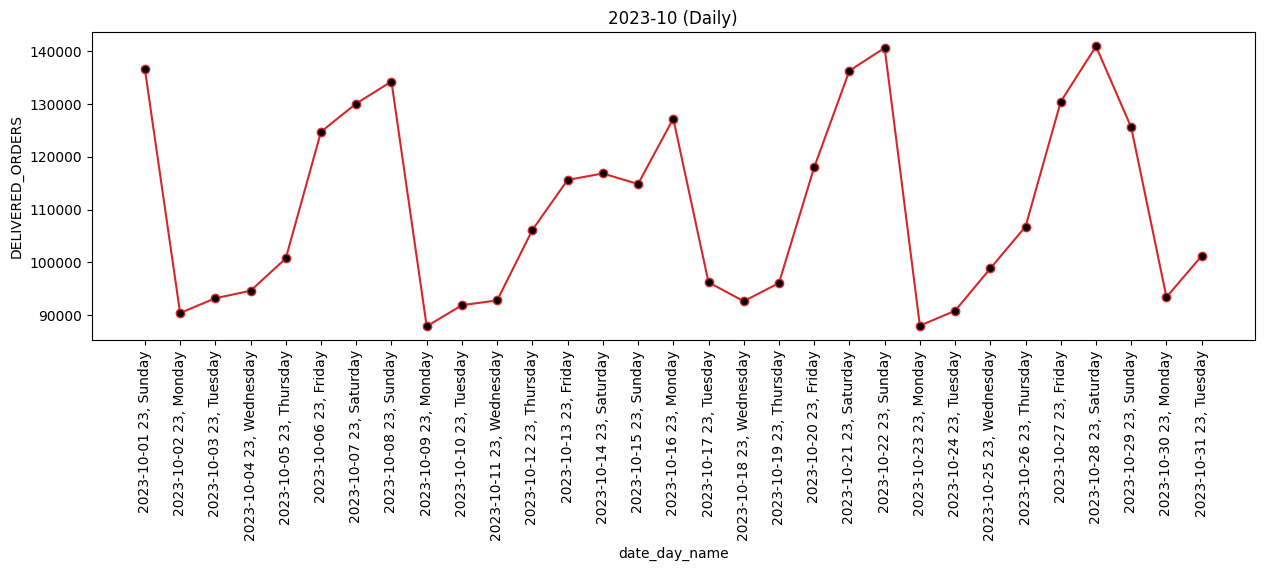

In [50]:
_plot_time_series(df_day.query("year == 2023 and month == 10"), 'date_day_name', 'DELIVERED_ORDERS', title="2023-10 (Daily)", rotation=90, marker='o')

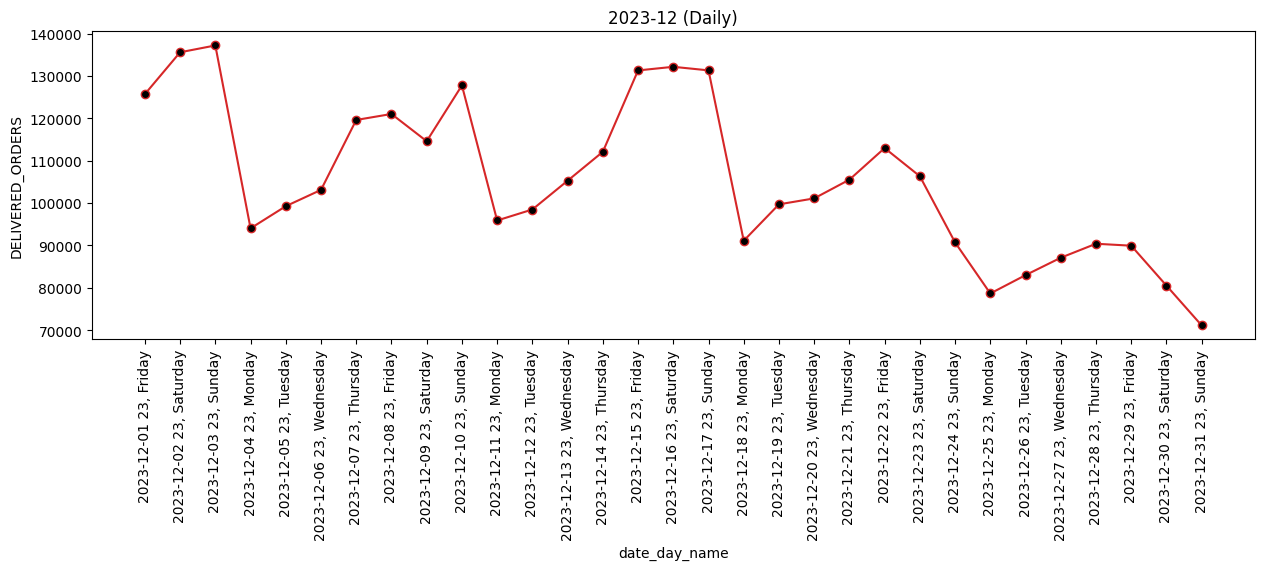

In [51]:
_plot_time_series(df_day.query("year == 2023 and month == 12"), 'date_day_name', 'DELIVERED_ORDERS', title="2023-12 (Daily)", rotation=90, marker='o')

Monthly time series:

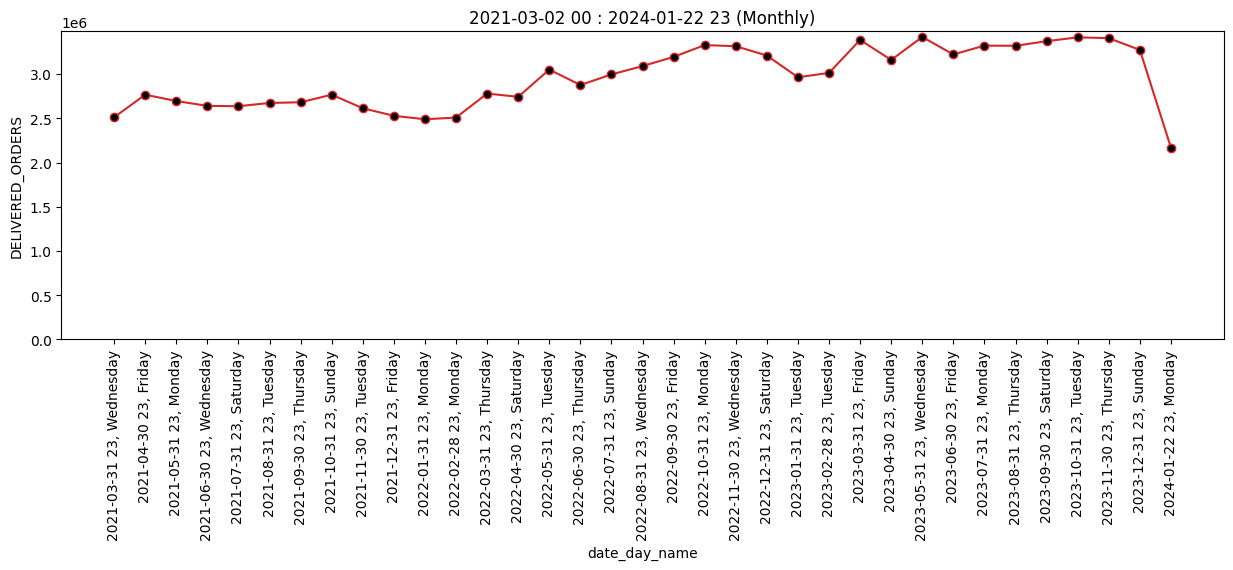

In [35]:
_plot_time_series(df_month, 'date_day_name', 'DELIVERED_ORDERS', title="2021-03-02 00 : 2024-01-22 23 (Monthly)", rotation=90, y_bottom=0, marker='o')

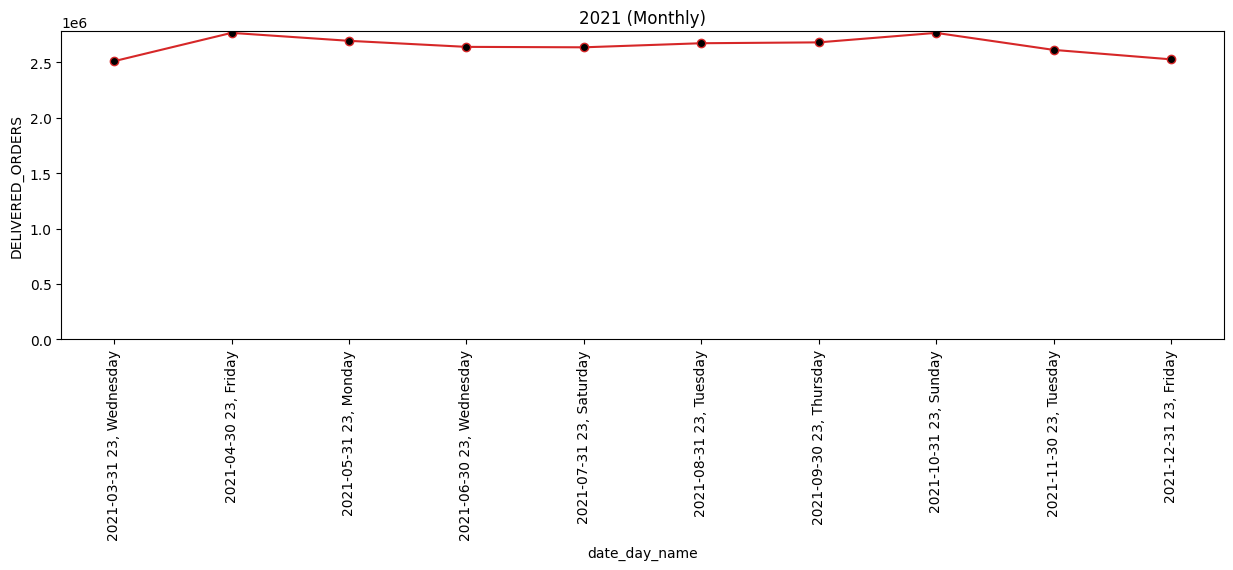

In [40]:
_plot_time_series(df_month.query('year == 2021'), 'date_day_name', 'DELIVERED_ORDERS', title="2021 (Monthly)", rotation=90, y_bottom=0, marker='o')

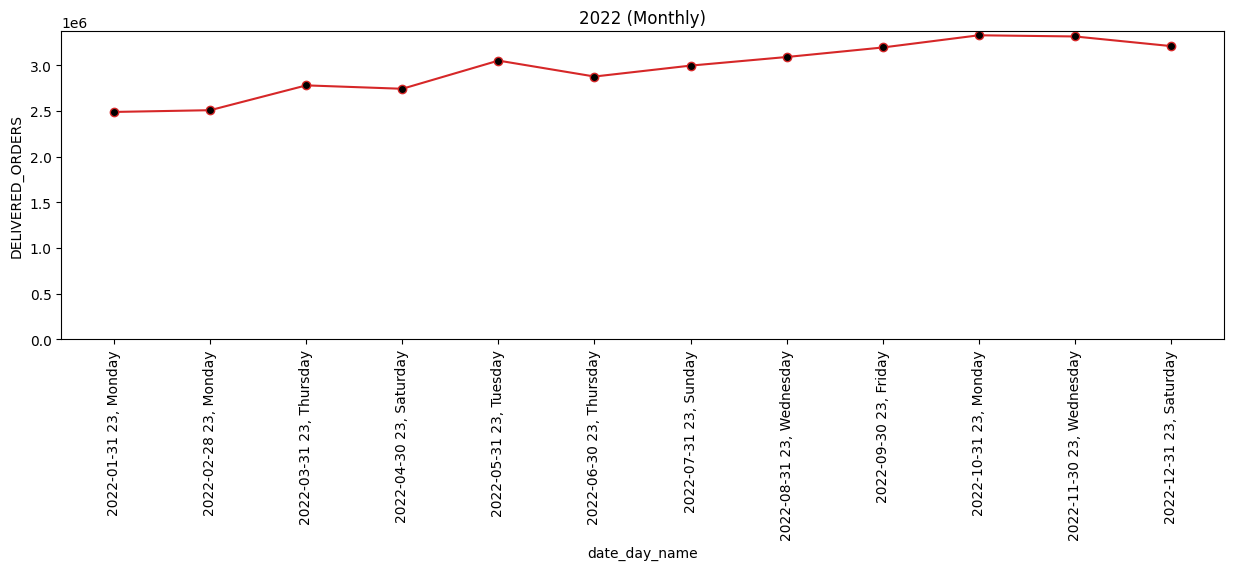

In [39]:
_plot_time_series(df_month.query('year == 2022'), 'date_day_name', 'DELIVERED_ORDERS', title="2022 (Monthly)", rotation=90, y_bottom=0, marker='o')

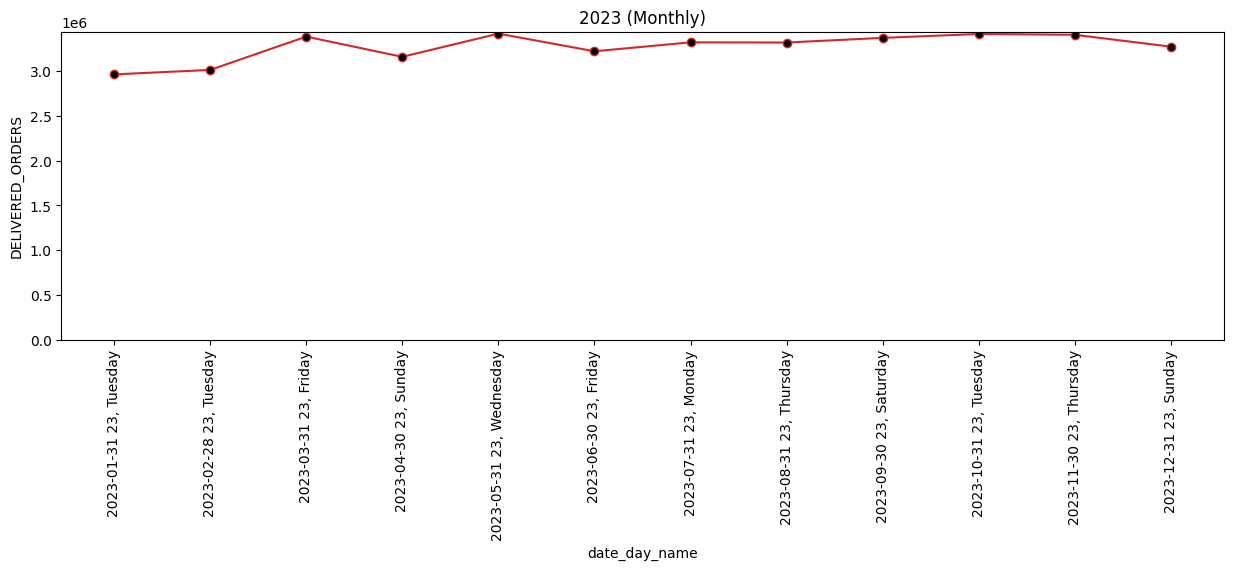

In [41]:
_plot_time_series(df_month.query('year == 2023'), 'date_day_name', 'DELIVERED_ORDERS', title="2023 (Monthly)", rotation=90, y_bottom=0, marker='o')

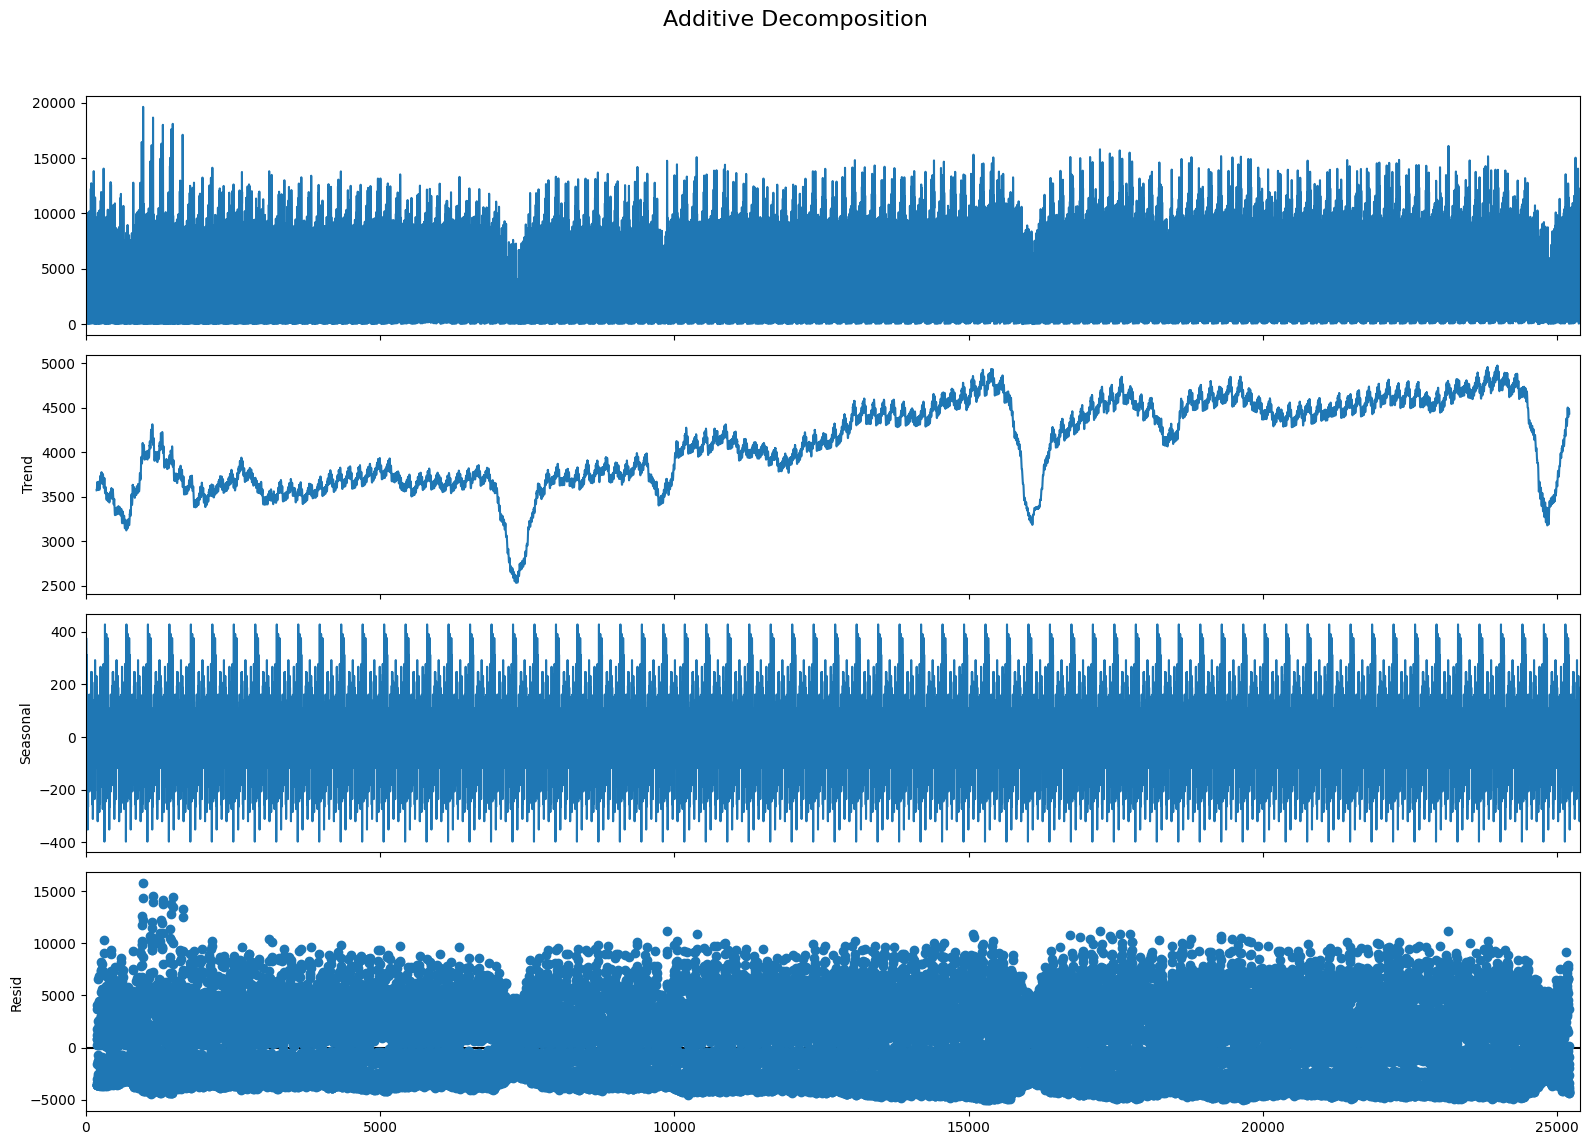

In [43]:
# Decomposition
multiplicative_decomposition = seasonal_decompose(data[['DELIVERED_ORDERS']], model='additive', period=365)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})

multiplicative_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

# Forecasting with Prophet


In [8]:
data['LOCAL_DATETIME'] = pd.to_datetime(data['LOCAL_DATETIME'])

In [9]:
train = data.query("year == 2021 or year == 2022 or year == 2023")[['LOCAL_DATETIME', 'DELIVERED_ORDERS']]
train.columns = ['ds', 'y']

test = data.query("year == 2024")[['LOCAL_DATETIME', 'DELIVERED_ORDERS']]
test.columns = ['ds', 'y_test']

In [10]:
train.head()

,ds,y
0,2021-03-02 00:00:00,122
1,2021-03-02 01:00:00,86
2,2021-03-02 02:00:00,38
3,2021-03-02 03:00:00,25
4,2021-03-02 04:00:00,14


In [11]:
print(train['ds'].min())
print(train['ds'].max())

2021-03-02 00:00:00
2023-12-31 23:00:00


In [12]:
test.head()

,ds,y_test
24840,2024-01-01 00:00:00,0
24841,2024-01-01 01:00:00,353
24842,2024-01-01 02:00:00,353
24843,2024-01-01 03:00:00,353
24844,2024-01-01 04:00:00,353


In [13]:
print(test['ds'].min())
print(test['ds'].max())

2024-01-01 00:00:00
2024-01-22 23:00:00


In [14]:
m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
m.fit(train)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpkp2apdfs/pp9v0782.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkp2apdfs/7m2q8uzw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26152', 'data', 'file=/tmp/tmpkp2apdfs/pp9v0782.json', 'init=/tmp/tmpkp2apdfs/7m2q8uzw.json', 'output', 'file=/tmp/tmpkp2apdfs/prophet_models3tdwau0/prophet_model-20240129112057.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:20:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:21:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [15]:
future = m.make_future_dataframe(periods=528, freq='H', include_history=False)
forecast = m.predict(future)

In [16]:
df_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
df_forecast.loc[df_forecast['yhat'] < 0, 'yhat'] = 0
df_forecast.loc[df_forecast['yhat_lower'] < 0, 'yhat_lower'] = 0
df_forecast.head()

,ds,yhat,yhat_lower,yhat_upper
0,2024-01-01 00:00:00,227.614401,0.0,1686.300820
1,2024-01-01 01:00:00,481.830555,0.0,1829.384542
2,2024-01-01 02:00:00,140.965865,0.0,1713.840110
3,2024-01-01 03:00:00,0.000000,0.0,918.616741
4,2024-01-01 04:00:00,0.000000,0.0,661.579282


In [17]:
df_forecast_test = pd.merge(df_forecast, test, on='ds', how='inner')
df_forecast_test.head()

,ds,yhat,yhat_lower,yhat_upper,y_test
0,2024-01-01 00:00:00,227.614401,0.0,1686.300820,0
1,2024-01-01 01:00:00,481.830555,0.0,1829.384542,353
2,2024-01-01 02:00:00,140.965865,0.0,1713.840110,353
3,2024-01-01 03:00:00,0.000000,0.0,918.616741,353
4,2024-01-01 04:00:00,0.000000,0.0,661.579282,353


In [18]:
mae = mean_absolute_error(df_forecast_test['y_test'], df_forecast_test['yhat'])
print(mae)

774.8708799419346


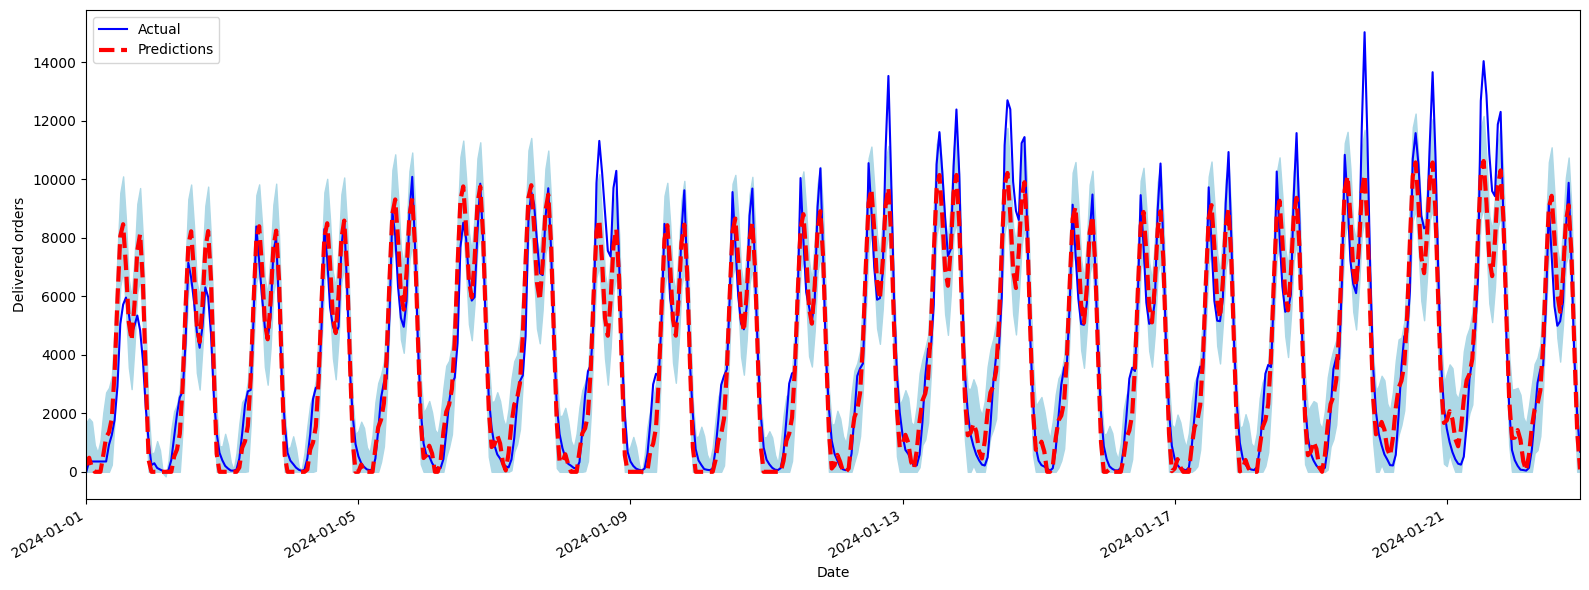

In [19]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(df_forecast_test['ds'], df_forecast_test['y_test'], 'b-', label='Actual')
ax.plot(df_forecast_test['ds'], df_forecast_test['yhat'], color='red', ls='--', lw=3, label='Predictions')

ax.set_xlabel('Date')
ax.set_ylabel('Delivered orders')

ax.legend(loc='best')

plt.fill_between(x=df_forecast_test['ds'], y1=df_forecast_test['yhat_lower'], y2=df_forecast_test['yhat_upper'], color='lightblue')
plt.xlim(df_forecast_test['ds'].min(), df_forecast_test['ds'].max())

fig.autofmt_xdate()
plt.tight_layout()

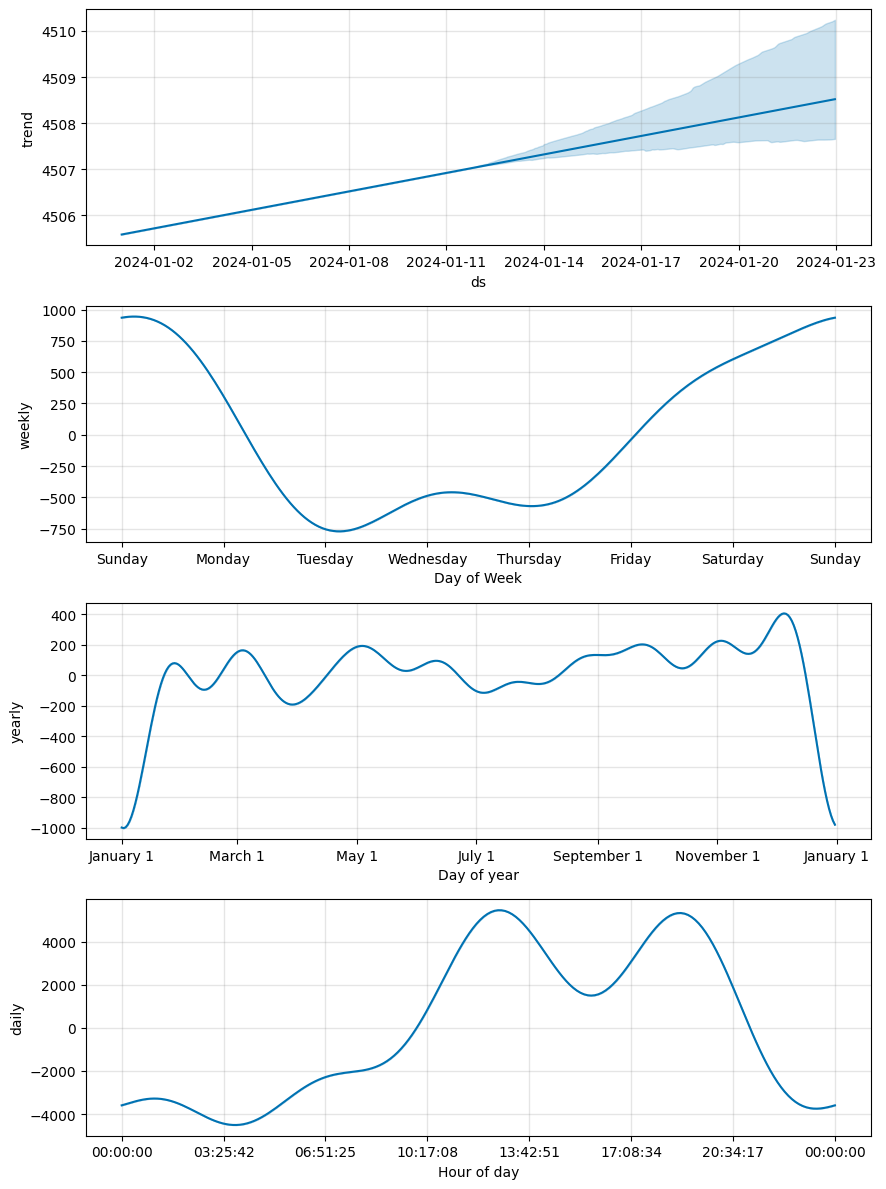

In [20]:
fig2 = m.plot_components(forecast)

## Predict the future

In [21]:
df = data[['LOCAL_DATETIME', 'DELIVERED_ORDERS']]
df.columns = ['ds', 'y']

print(df['ds'].min())
print(df['ds'].max())

m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
m.fit(df)

future = m.make_future_dataframe(periods=24*7, freq='H', include_history=True)

forecast = m.predict(future)

df_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
df_forecast.loc[df_forecast['yhat'] < 0, 'yhat'] = 0
df_forecast.loc[df_forecast['yhat_lower'] < 0, 'yhat_lower'] = 0

2021-03-02 00:00:00
2024-01-22 23:00:00


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkp2apdfs/awgywv3z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkp2apdfs/5ctd0786.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23447', 'data', 'file=/tmp/tmpkp2apdfs/awgywv3z.json', 'init=/tmp/tmpkp2apdfs/5ctd0786.json', 'output', 'file=/tmp/tmpkp2apdfs/prophet_modelz4gyqnq5/prophet_model-20240129112226.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:22:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:22:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [22]:
df_complete = pd.merge(df_forecast, df, on='ds', how='left')
df_complete.tail(24)

,ds,yhat,yhat_lower,yhat_upper,y
25512,2024-01-29 00:00:00,1400.383002,0.000000,3017.236728,NaN
25513,2024-01-29 01:00:00,1654.722597,132.570573,3197.304621,NaN
25514,2024-01-29 02:00:00,1315.507802,0.000000,2848.852806,NaN
25515,2024-01-29 03:00:00,581.222994,0.000000,2136.430387,NaN
25516,2024-01-29 04:00:00,266.569461,0.000000,1824.798230,NaN
25517,2024-01-29 05:00:00,798.086469,0.000000,2327.548713,NaN
25518,2024-01-29 06:00:00,1742.645006,250.790634,3335.791598,NaN
25519,2024-01-29 07:00:00,2358.566927,912.794058,3904.392056,NaN
25520,2024-01-29 08:00:00,2528.176064,1029.985595,4054.966528,NaN
25521,2024-01-29 09:00:00,2996.865413,1420.244365,4449.215356,NaN


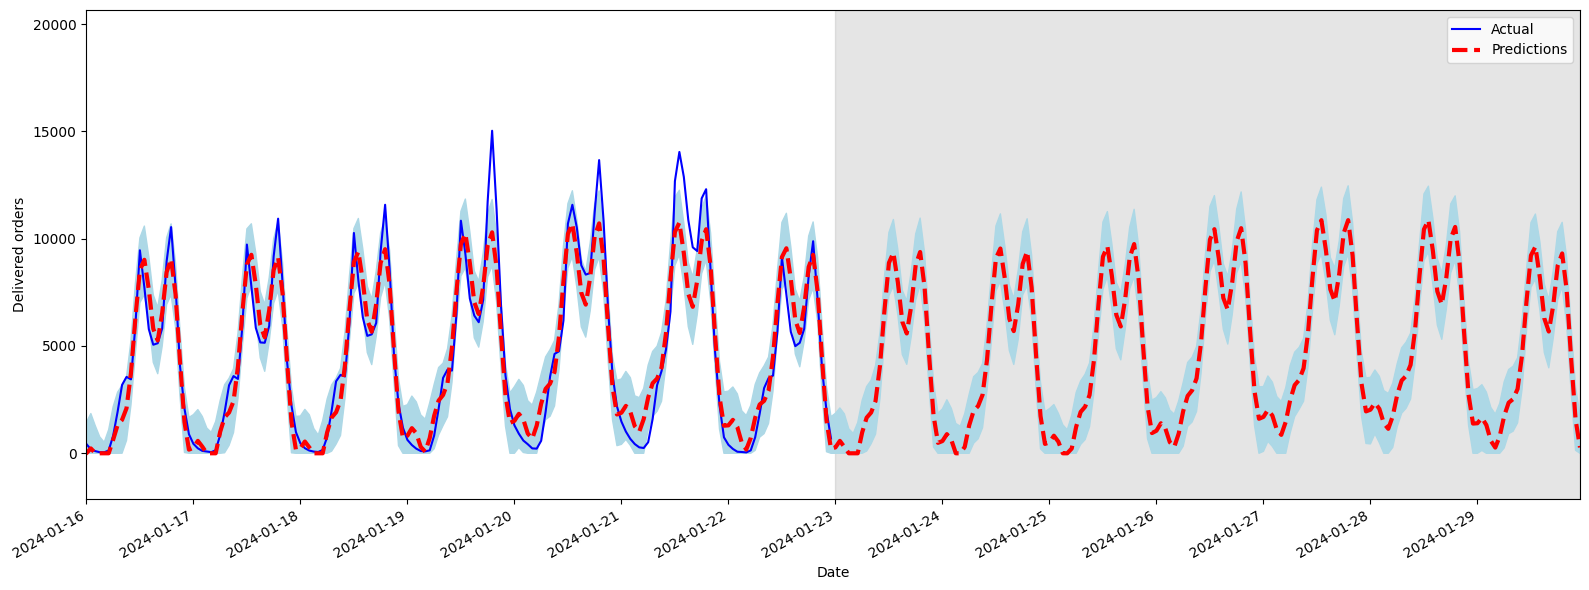

In [23]:
start_date_prediction = datetime.strptime('2024-01-16 00:00:00', "%Y-%m-%d %H:%M:%S")
end_date_prediction = df_complete['ds'].max()

fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(df_complete['ds'], df_complete['y'], 'b-', label='Actual')
ax.plot(df_complete['ds'], df_complete['yhat'], color='red', ls='--', lw=3, label='Predictions')

ax.set_xlabel('Date')
ax.set_ylabel('Delivered orders')

ax.axvspan('2024-01-23 00:00:00', end_date_prediction, color='#808080', alpha=0.2)

ax.legend(loc='best')

plt.xticks(pd.date_range(start=start_date_prediction, end=end_date_prediction, freq='D'))

plt.fill_between(x=df_complete['ds'], y1=df_complete['yhat_lower'], y2=df_complete['yhat_upper'], color='lightblue')
plt.xlim(start_date_prediction, end_date_prediction)

fig.autofmt_xdate()
plt.tight_layout()